Next, we will explore the creation of the initial conditions.

First, import packages to create and visualize the model fields here:

In [1]:
# import the modules for computation, plotting, and reading files
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4

# import the necessary modules from eccoseas
from eccoseas.ecco import io
from eccoseas.downscale import hFac
from eccoseas.downscale import horizontal

## Constructing the Initial Conditions
The initial conditions for this model will be generated by interpolating from a model state from the ECCO Version 5 state estimate using the **eccoseas** tools.

This construction will proceed in 6 steps:
1. download the pertinent ECCO fields
2. read the ECCO model grid
3. read in the bathymetry for the regional model as well as its grid
4. prepare the ECCO fields for interpolation
5. interpolate the ECCO fields onto the regional model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected
7. prepare notes on the run-time options to implement this initial condition approach

### Step 1: Download the ECCO fields
To begin, download the model fields generated by the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/nctiles_monthly).

In particular, download the following list of files that contain the field pertaining to starting point of the model (January 2008):

| Variable | File Name |
| -------- | --------- |
|THETA|THETA/THETA_2008.nc|
|SALT|SALT/SALT_2008.nc|
|UVEL|UVELMASS/UVELMASS_2008.nc|
|VVEL|VVELMASS/VVELMASS_2008.nc|
|ETAN|ETAN/ETAN_2008.nc|

These fields in the following directory:

In [2]:
data_folder = '../../../data/california'

### Step 2: Read in the ECCO grid
To read in the ECCO fields, we use the `io` module from the `eccoseas.ecco` package:

In [3]:
ecco_XC_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='XC')
ecco_YC_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='YC')
ecco_hFacC_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacC')
ecco_hFacW_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacW')
ecco_hFacS_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacS')
ecco_RF_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='RF')
ecco_DRF_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='DRF')

As described [HERE](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Plotting_Tiles.html), the ECCO grid has 13 tiles but only 1 or 2 may pertain to my local area. To determine which tiles correspond to the model grid region, read in my model grid next.

### Step 3: Read in the Model Grid and Generate a Mask
Here, we recreate the grid used in  the regional model and read in the bathymetry file (see previous notebooks for details):

In [4]:
# define the input directory (constructed in the previous notebook for bathymetry)
# this directory should already have the bathymetry file called CA_bathymetry.bin
input_dir = '../../../configurations/california/input'

In [5]:
# define the parameters that will be used in the data file
delX = 1/12
delY = 1/16
xgOrigin = -135
ygOrigin = 29
n_rows = 360
n_cols = 240

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'CA_bathymetry.bin'),'>f4').reshape(np.shape(XC))

With an eye toward the interpolation to come next, we will make a mask to determine where the interpolatation will take place. In this example, we will create this mask by recreating the `hFac` field for the model using the `hFac` module from the `eccoseas` package: 

In [6]:
# this model will use the same vertical spacing as the ECCO Version 5 configuration
delR = ecco_DRF_tiles[1]

# generate the hFac grids - this may take a few minutes
hFacC = hFac.create_hFacC_grid(bathy, delR)
hFacS = hFac.create_hFacS_grid(bathy, delR)
hFacW = hFac.create_hFacW_grid(bathy, delR)

The interpolation masks are generated by setting all of the non-zero `hFac` points to 1:

In [7]:
# generate the masks
maskC = np.copy(hFacC)
maskC[maskC>0] = 1

maskS = np.copy(hFacS)
maskS[maskS>0] = 1

maskW = np.copy(hFacW)
maskW[maskW>0] = 1

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

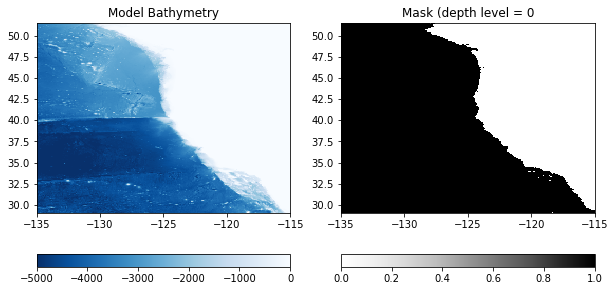

In [8]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, maskC[0,:,:], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

### Step 4: Prepare the grids for interpolation
At this point, we can use the geometry of both grids to check to see which tiles have the information we need. By looking at the layout of the ECCO tiles, we find that tiles 8 and 11 have the points I need:

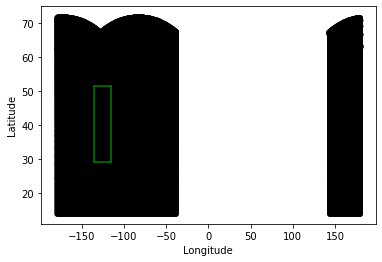

In [9]:
# formulate the tile list
tile_list = [8,11]

# plot the ECCO tile points from the specified tiles
for tile in tile_list:
    plt.plot(ecco_XC_tiles[tile],ecco_YC_tiles[tile],'k.')

# plot the boundary of the CA model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As we can see, the regional model boundary (green) is completely surrounded by the points in tiles 8 and 11 (black). We also note that there is extraneous information in points with positive longitudes. We will omit these points below to speed up the interpolation. Given these observations, we now read in points from just those tiles to use in interpolation:

In [10]:
# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_maskC_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_maskW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_maskS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
    
    for k in range(np.size(ecco_RF_tiles[tile_number])):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        if tile_number<7:
            level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
            level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        else:
            level_hFacS = ecco_hFacW_tiles[tile_number][k, :, :] # these are switched due to the 
            level_hFacW = ecco_hFacS_tiles[tile_number][k, :, :] # assumptions about velocity - see note below
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        level_maskC = np.copy(level_hFacC)
        level_maskC[level_maskC>0] = 1
        level_maskW = np.copy(level_hFacW)
        level_maskW[level_maskW>0] = 1
        level_maskS = np.copy(level_hFacS)
        level_maskS[level_maskS>0] = 1
        ecco_maskC_points[k, points_counted:points_counted+tile_N] = level_maskC.ravel()
        ecco_maskW_points[k, points_counted:points_counted+tile_N] = level_maskW.ravel()
        ecco_maskS_points[k, points_counted:points_counted+tile_N] = level_maskS.ravel()
    
    points_counted += tile_N

# remove the points with positive longitude
local_indices = ecco_XC_points<0
ecco_maskC_points = ecco_maskC_points[:, local_indices]
ecco_maskW_points = ecco_maskW_points[:, local_indices]
ecco_maskS_points = ecco_maskS_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [11]:
# make a file dictionary to loop over

file_prefix_dict = {'ETAN':'ETAN_2008.nc',
                    'THETA':'THETA_2008.nc',
                    'SALT':'SALT_2008.nc',
                    'UVEL':'UVELMASS_2008.nc',
                    'VVEL':'VVELMASS_2008.nc'}

variable_names = list(file_prefix_dict.keys())

Now, read the initial condition fields from the same tiles:

In [12]:
# make a list to hold all of the ECCO grids
init_grids = []

# loop through each variable to read in the grid
for variable_name in variable_names:
    
    if variable_name == 'ETAN':
        ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
        grid = ds.variables[variable_name][:,:,:,:]
        ds.close()
        grid = grid[0, :, :, :] # first timestep (january)
    elif 'VEL' in variable_name:
        ds = nc4.Dataset(os.path.join(data_folder,'UVELMASS_2008.nc'))
        u_grid = ds.variables['UVELMASS'][:,:,:,:,:]
        u_grid = u_grid[0, :, :, :, :] # first timestep (january)
        ds.close()
        ds = nc4.Dataset(os.path.join(data_folder,'VVELMASS_2008.nc'))
        v_grid = ds.variables['VVELMASS'][:,:,:,:,:]
        ds.close()
        v_grid = v_grid[0, :, :, :, :] # first timestep (january)
    else:
        ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
        grid = ds.variables[variable_name][:,:,:,:,:]
        ds.close()
        grid = grid[0, :, :, :, :] # first timestep (january)
    
    # create a grid of zeros to fill in
    N = np.shape(grid)[-1]*np.shape(grid)[-2]
    if variable_name == 'ETAN':
        init_grid = np.zeros((1, N*len(tile_list)))
    else:
        init_grid = np.zeros((np.size(ecco_RF_tiles[1]), N*len(tile_list)))

    # loop through the tiles
    points_counted = 0
    for tile_number in tile_list:
        if variable_name == 'ETAN':
            init_grid[0,points_counted:points_counted+N] = \
                 grid[tile_number-1, :, :].ravel()
        elif 'VEL' in variable_name: # when using velocity, need to consider the tile rotations (see note below)
            if variable_name == 'UVEL':
                if tile_number<7:
                    for k in range(np.size(ecco_RF_tiles[1])):             
                        init_grid[k,points_counted:points_counted+N] = \
                             u_grid[k, tile_number-1, :, :].ravel()
                else:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             v_grid[k, tile_number-1, :, :].ravel()
            if variable_name == 'VVEL':
                if tile_number<7:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             v_grid[k, tile_number-1, :, :].ravel()
                else:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             -1*u_grid[k, tile_number-1, :, :].ravel()
        else:
            for k in range(np.size(ecco_RF_tiles[1])):
                init_grid[k,points_counted:points_counted+N] = \
                     grid[k, tile_number-1, :, :].ravel()
        points_counted += N

    # apply some corrections to convert UVELMASS and VVELMASS to UVEL and VVEL
    if variable_name == 'UVEL':
        for k in range(np.size(ecco_RF_tiles[1])):
            non_zero_indices = ecco_hFacW_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacW_points[k,non_zero_indices])
    if variable_name == 'VVEL':
        for k in range(np.size(ecco_RF_tiles[1])):
            non_zero_indices = ecco_hFacS_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacS_points[k,non_zero_indices])

    # remove the points with positive longitudes
    init_grid = init_grid[:,local_indices]
    
    init_grids.append(init_grid)

### Step 5: Interpolate the Fields onto the Model Grid
Next, we will interpolate the ECCO fields we read in onto the regional model domain. Here, we will use the `horizontal` module from the `eccoseas` package to accomplish this interpolation.

In [13]:
# loop through each variable and corresponding ECCO grid
for variable_name, init_grid in zip(variable_names, init_grids):

    print('    - Interpolating the '+variable_name+' grid')

    # read in the correct mask for each variable
    if variable_name == 'ETAN':
        regional_mask = maskC[:1,:,:]
        ecco_mask = ecco_maskC_points[:1,:]
    elif variable_name == 'UVEL':
        regional_mask = maskW
        ecco_mask = ecco_maskW_points
    elif variable_name == 'VVEL':
        regional_mask = maskS
        ecco_mask = ecco_maskS_points
    else:
        regional_mask = maskC
        ecco_mask = ecco_maskC_points

    # run the interpolation scheme
    interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                       init_grid, ecco_mask, 
                                                       XC, YC, regional_mask, testing=False) # testing will only interpolate the
                                                                                         # first level, use for testing and then
                                                                                         # be sure to uncomment when creating the
                                                                                         # actual initial conditions


    # output the interpolated grid
    output_file = os.path.join(input_dir,variable_name+'_IC.bin')
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

    - Interpolating the ETAN grid
    - Interpolating the THETA grid
    - Interpolating the SALT grid
    - Interpolating the UVEL grid
    - Interpolating the VVEL grid


### Step 6: Plotting the Initial Condition Fields
Now that the fields have been generated, we will plot them to ensure they look as expected. First, generate some metadata for each one to design the look of the plot:

In [14]:
meta_dict = {'ETAN':[0.1, 0.5, 'viridis', 'm'],
            'THETA':[6, 18, 'turbo', 'm'],
            'SALT':[32, 35, 'viridis', 'm'],
            'UVEL':[-0.25, 0.25, 'seismic', 'm'],
            'VVEL':[-0.25, 0.25, 'seismic', 'm']}

Then, create all of the subplots:

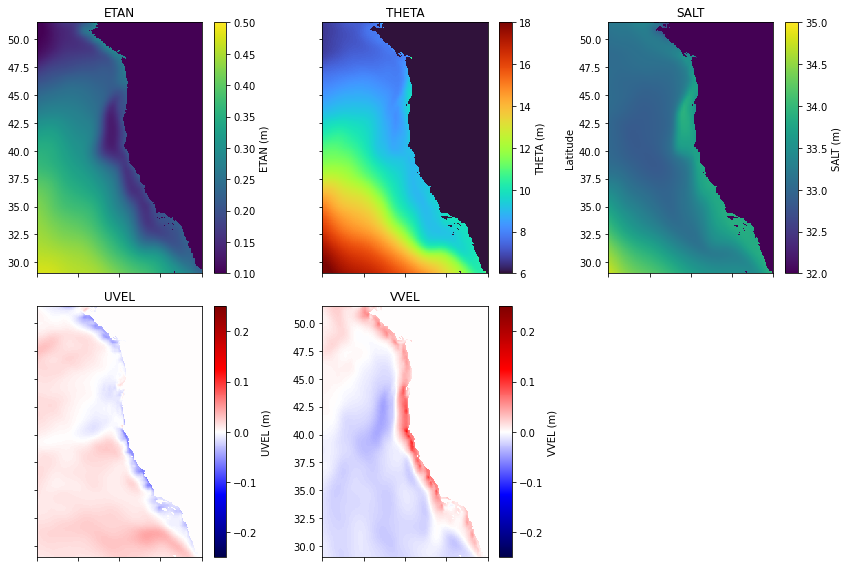

In [15]:
fig = plt.figure(figsize=(12,8))


for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    CA_init_grid = np.fromfile(os.path.join(input_dir,variable_name+'_IC.bin'),'>f4')

    if variable_name == 'ETAN':
        CA_init_grid = CA_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
    else:
        CA_init_grid = CA_init_grid.reshape((np.shape(delR)[0],np.shape(XC)[0], np.shape(XC)[1]))
        CA_init_grid = CA_init_grid[0, :, :] # choose just the surface for plotting
    
    plt.subplot(2,3,i+1)
    C = plt.pcolormesh(XC, YC, CA_init_grid,
                       vmin=meta_dict[variable_names[i]][0],
                       vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.26)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')
    plt.title(variable_name)

plt.tight_layout()

plt.show()

Looks good! Now we need to make our external forcing and boundary conditions before we're ready to run the model.

.. note::
    Note: For the velocity fields, we have implicitly assumed that the direction of the velocity field is in the correct orientation i.e. that UVEL points east and VVEL points north. For this region of the globe, this is approximately true and this assumption only leads to small errors. However, this is not true in general. The next two regional model domains require closer consideration of these fields. See the following examples to learn how to deal with these grid issues.


### Step 7: Run-time considerations
To use the grids as initial conditions in the model, we can specify them as "hydrography" conditions in the `data` file. Specifically, I will add the following lines to `PARM05` of the data file:

```
hydrogThetaFile = 'THETA_IC.bin',
hydrogSaltFile = 'SALT_IC.bin',
uVelInitFile = 'UVEL_IC.bin',
vVelInitFile = 'VVEL_IC.bin',
pSurfInitFile = 'ETAN_IC.bin',
```

Note that `nIter=0` must be set to use these conditions.